In [5]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utils import Namespace, set_weights
from src.score_solution import reverse_sde

In [2]:
def normalize(imgs):
    """
    Normalize the images to the range [0, 1]
    """
    imgs = imgs.cpu().detach().numpy()
    imgs =  (imgs+1)*0.5
    imgs = np.clip(imgs, 0, 1)
    return imgs

def show_images(images, args, sde ):
    """
    Show images in a grid,行列转置
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(args.batchsize, 12, figsize=(10, 5)) 
    for i in range(11):
        index = max(0, i*100-1)
        imgs = normalize(images[index])
        for j in range(args.batchsize):
            ax = axes[j, i]  # 行列转置
            ax.imshow(imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title(f"t = {index}", fontsize=10)
    
    if args.start == 'sub_noise':
        # 显示原始图像
        original_imgs = normalize(sde.sample)
        for j in range(args.batchsize):
            ax = axes[j, 11]
            ax.imshow(original_imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title("Image", fontsize=10)
    else:
        for j in range(args.batchsize):
            ax = axes[j, 11]
            # ax.imshow(original_imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            
    plt.suptitle(f'start {args.start}')
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    

pure noise start

Using device: cuda:4


sampling loop time step:   4%|▎         | 35/1000 [00:00<00:06, 155.07it/s]

t=999, tensor([ 401,  819,  641,  960,  337,  913, 1293,  430], device='cuda:4')
t=950, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  14%|█▍        | 140/1000 [00:00<00:02, 297.76it/s]

t=900, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=850, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  24%|██▍       | 245/1000 [00:00<00:02, 328.63it/s]

t=800, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=750, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  35%|███▌      | 350/1000 [00:01<00:01, 339.75it/s]

t=700, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=650, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  46%|████▌     | 457/1000 [00:01<00:01, 345.97it/s]

t=600, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=550, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  56%|█████▋    | 563/1000 [00:01<00:01, 339.28it/s]

t=500, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=450, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  67%|██████▋   | 669/1000 [00:02<00:00, 344.02it/s]

t=400, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=350, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  74%|███████▍  | 740/1000 [00:02<00:00, 345.46it/s]

t=300, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=250, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  85%|████████▍ | 846/1000 [00:02<00:00, 349.20it/s]

t=200, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=150, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step:  95%|█████████▌| 951/1000 [00:02<00:00, 347.56it/s]

t=100, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')
t=50, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 325.50it/s]


t=0, tensor([1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275], device='cuda:4')


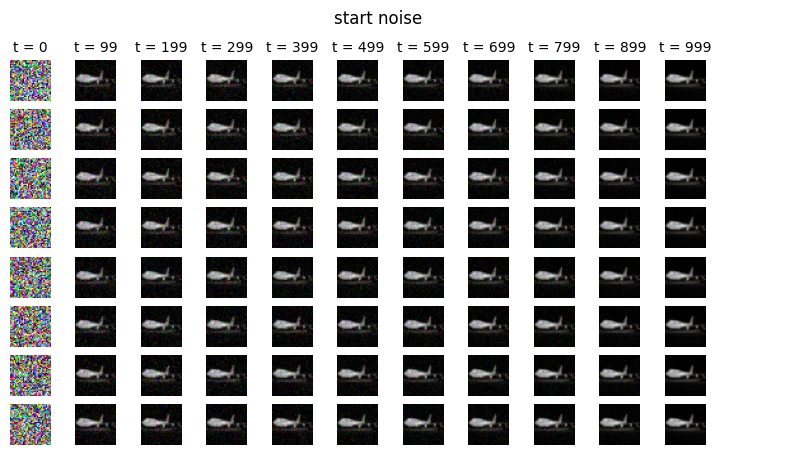

In [ ]:
args = Namespace(
    sde_version='vp',
    device=4,
    timesteps=1000,
    start='noise',
    batchsize=8,
    temperature=5.0)
weights = set_weights(args)
sde = reverse_sde(args, weights)

images = sde.p_sample_loop(return_all_time_steps=True)
show_images(images, args, sde)

sub noise start

Using device: cuda:4


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

t=999, tensor([ 946, 1253,  189,  716,  405, 1959,  861,  353], device='cuda:4')


sampling loop time step:   6%|▋         | 64/1000 [00:00<00:02, 314.94it/s]

t=950, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  10%|▉         | 97/1000 [00:00<00:02, 318.73it/s]

t=900, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  16%|█▋        | 165/1000 [00:00<00:02, 327.46it/s]

t=850, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  20%|██        | 200/1000 [00:00<00:02, 332.68it/s]

t=800, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  24%|██▎       | 236/1000 [00:00<00:02, 336.58it/s]

t=750, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  30%|███       | 304/1000 [00:00<00:02, 331.95it/s]

t=700, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  34%|███▍      | 338/1000 [00:01<00:01, 331.64it/s]

t=650, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  41%|████      | 406/1000 [00:01<00:01, 334.08it/s]

t=600, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  44%|████▍     | 440/1000 [00:01<00:01, 334.86it/s]

t=550, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  51%|█████     | 510/1000 [00:01<00:01, 339.14it/s]

t=500, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  55%|█████▍    | 546/1000 [00:01<00:01, 342.65it/s]

t=450, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  62%|██████▏   | 616/1000 [00:01<00:01, 341.66it/s]

t=400, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  65%|██████▌   | 651/1000 [00:01<00:01, 341.75it/s]

t=350, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  69%|██████▊   | 686/1000 [00:02<00:00, 342.41it/s]

t=300, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  76%|███████▌  | 756/1000 [00:02<00:00, 338.20it/s]

t=250, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  79%|███████▉  | 791/1000 [00:02<00:00, 341.17it/s]

t=200, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  86%|████████▌ | 861/1000 [00:02<00:00, 341.89it/s]

t=150, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  90%|████████▉ | 896/1000 [00:02<00:00, 343.38it/s]

t=100, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step:  97%|█████████▋| 966/1000 [00:02<00:00, 341.91it/s]

t=50, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


sampling loop time step: 100%|██████████| 1000/1000 [00:02<00:00, 337.31it/s]

t=0, tensor([1078, 1275, 1078, 1078, 1275, 1078, 1078, 1078], device='cuda:4')


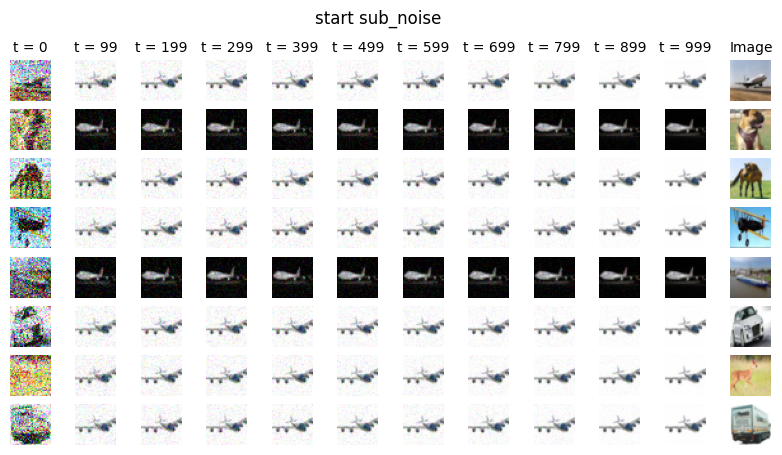

In [4]:
args = Namespace(
    sde_version='vp',
    device=4,
    timesteps=1000,
    start='sub_noise',
    batchsize=8)
weights = set_weights(args)
sde = reverse_sde(args, weights)

images = sde.p_sample_loop(return_all_time_steps=True)
show_images(images, args, sde)